# Brain Tumor Detection Model: Neural Networks

## Cleaning and Cropping the Images


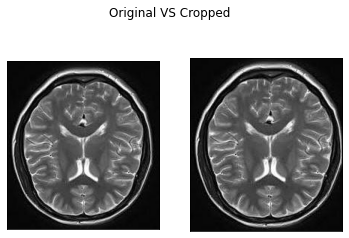

In [1]:
import cv2
import imutils
from skimage import io
import matplotlib.pyplot as plt


def image_cropper(image, plot = False):
    #import the libraries to perform cropping

    
    
    #apply gray scale and slight blur to image (for image processing)
    gscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gscale = cv2.GaussianBlur(gscale, (45, 35), 0)
    
    #apply binary threshold and further process the image using erode and dilate
    thresh = cv2.threshold(gscale, 35, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=3)
    thresh = cv2.dilate(thresh, None, iterations=3)
    
    #find the maximum value contour (using area) of the models
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)

    cnts = imutils.grab_contours(cnts)
    area = cv2.contourArea
    
    c = max(cnts, key = area)
    

    
    #find the extremas of the contours (contours is really 2 dimensional)
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    #crop the image using the extremas
    cropped_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]] 
    

    if plot == True:
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle('Original VS Cropped')

        ax1.tick_params(axis = 'both', which = 'both', bottom = False, left = False, 
                            labelbottom = False, labelleft=False)
        ax2.tick_params(axis = 'both', which = 'both', bottom = False, left = False, 
                            labelbottom = False, labelleft=False)
    
        ax1.imshow(image)
        
     
        ax2.imshow(cropped_image)

    

    return cropped_image

   
    

image = cv2.imread('negative/no11.jpg')
bruh = image_cropper(image, True)

        

In [2]:
import os
from sklearn.utils import shuffle
import numpy as np
from sklearn.utils import shuffle

def finalizer(dirs, width = 240, height = 240):
    #resize images and normalize them for neural networks
    #will final positive and negative images in one succesion
    
    x = []
    y = []
    
    for dirc in dirs:
        for name in os.listdir(dirc):
            
            #read the image
            image = cv2.imread(dirc  + name)
            #crop the image
            image = image_cropper(image)
            #resize the image and apply interpolation
            image = cv2.resize(image, dsize=(width, height), interpolation=cv2.INTER_CUBIC)
     
            x.append(image)
            if 'pos' in dirc:
                y.append([1])
            else:
                y.append([0])
            
            
            

    x = np.array(x)
    y = np.array(y)
    x,y = shuffle(x, y)
    
    return x,y
    

    
    
            

In [3]:
def plot_images(x, y, n=50):
    #verify that previous image processing is valid by graphing sample set
    
    for cate in [0,1]:
        #find all images in respective category
        images = x[np.argwhere(y == cate)]
        images = images[:n]
        
        #configure values for figure graph
        columns = 10
        rows = int(n / columns)
        plt.figure(figsize = (20, 10))
        
        #starting plot
        i = 1         
        for image in images:
            plt.subplot(rows, columns, i)
            plt.imshow(image[0])
            
            #discard graph axes
            plt.tick_params(axis = 'both', which = 'both', bottom = False, left = False, 
                            labelbottom = False, labelleft=False)
            
            i += 1
        
        label_to_str = lambda label: "Positive" if label == 1 else "Negative"
        plt.suptitle(f"Tumor: {label_to_str(cate)}")

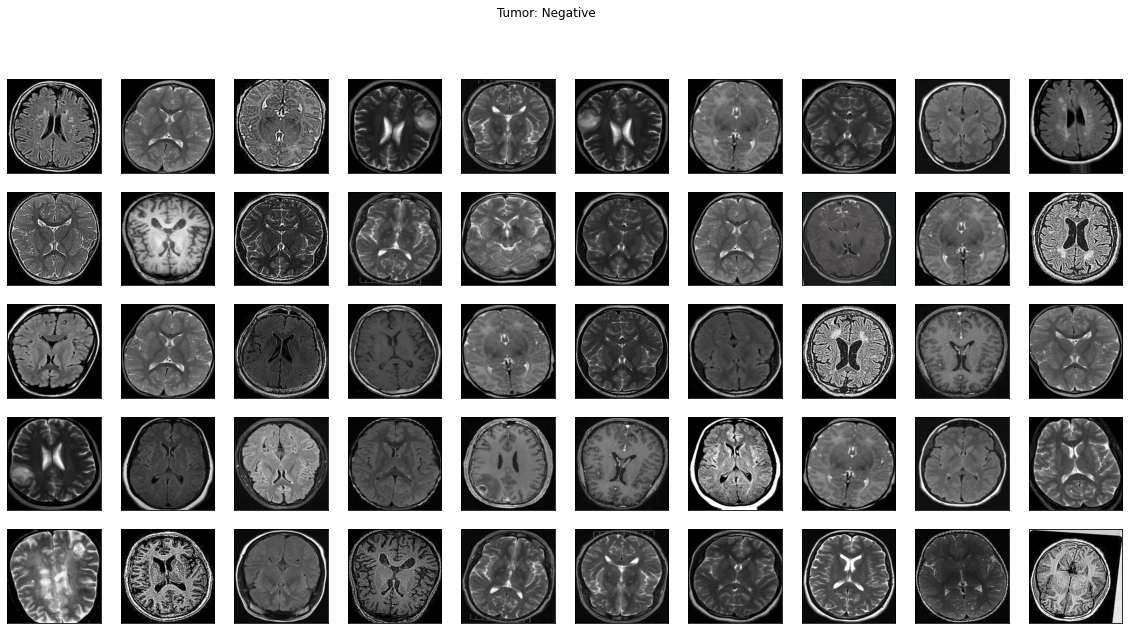

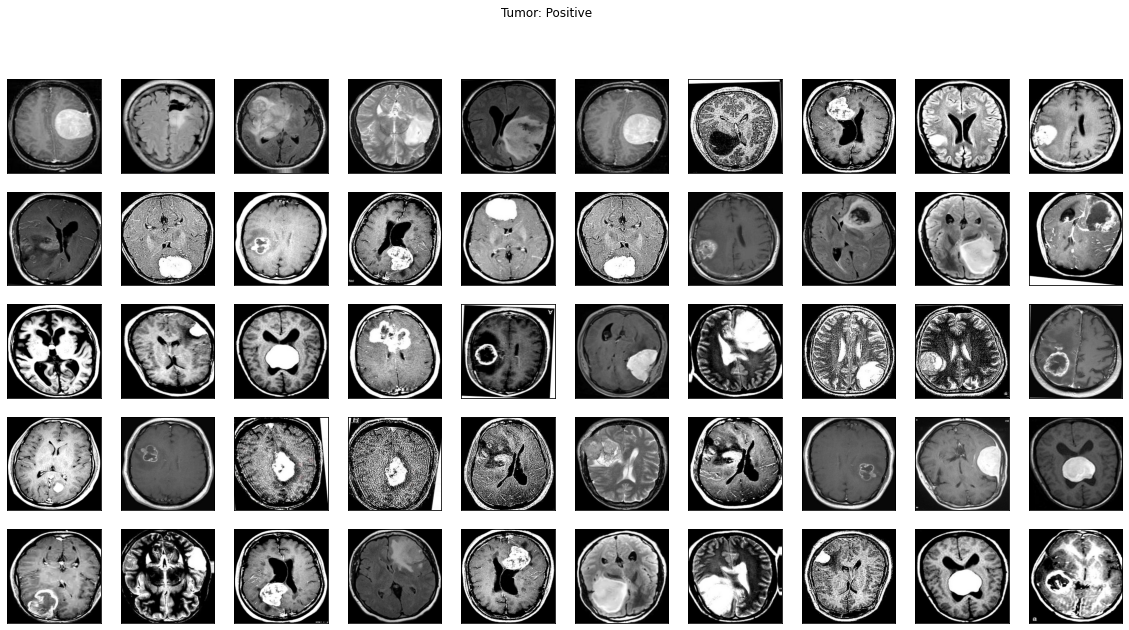

In [4]:
x,y = finalizer(["augmented neg/", "augmented pos/"])
plot_images(x,y)

## Creating the Neural Network Model

In [5]:
from sklearn.model_selection import train_test_split
#create a training data set using x,y
#70% training, 15% validation, 15% test

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size = 0.5)

#examine how dataset has been partitioned
print('Training: {:>5}'.format(x_train.shape[0]))
print('Validation: {:>3}'.format(x_val.shape[0]))
print('Testing: {:>6}'.format(x_test.shape[0]))
print()
print('x_train shape: ', x_train.shape)
print('y_train shape: ', y_train.shape)
print('x_val shape: ', x_val.shape)
print('y_val shape: ', y_val.shape)
print('x_test shape:', x_test.shape)
print('y_test shape: ', y_test.shape)


Training:  1120
Validation: 240
Testing:    240

x_train shape:  (1120, 240, 240, 3)
y_train shape:  (1120, 1)
x_val shape:  (240, 240, 240, 3)
y_val shape:  (240, 1)
x_test shape: (240, 240, 240, 3)
y_test shape:  (240, 1)


In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
#build the model

#create tensor with correct shape
x_input = Input((240, 240, 3))
#add padding to x_input with 0s
x = ZeroPadding2D((2, 2))(x_input)


#create convolutional layer with 32 filters
x = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(x)
#normalize inputs to convolutional layer
x = BatchNormalization(axis = 3, name = 'bn0')(x)
#apply activation function to output
x = Activation('relu')(x) 

#use maxpooling to downsample input along spaital dimensions
x = MaxPooling2D((4, 4), name='max_pool0')(x) 
#use maxpooling to downsample input along spaital dimensions
x = MaxPooling2D((4, 4), name='max_pool1')(x)

#convert multi-dimensional singal to single-dimension
x = Flatten()(x)
#apply fullyconnected feature extraction layer
x = Dense(1, activation='sigmoid', name='fc')(x)
    
#create Keras model instance
model = Model(inputs = x_input, outputs = x, name = 'Tumor_Detection_Model')

#examine the model
model.summary()

Model: "Tumor_Detection_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 244, 244, 3)      0         
 2D)                                                             
                                                                 
 conv0 (Conv2D)              (None, 238, 238, 32)      4736      
                                                                 
 bn0 (BatchNormalization)    (None, 238, 238, 32)      128       
                                                                 
 activation (Activation)     (None, 238, 238, 32)      0         
                                                                 
 max_pool0 (MaxPooling2D)    (None, 59, 59, 32)        0         
                                             

In [7]:
#properly format the time elapsed
def timer(length):
    h = int(length / 3600)
    m = int((length % 3600) / 60)
    s = (length % 3600) % 60
    return f"{h}:{m}:{s:.2f}"

In [8]:
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
import time

#compile the model
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

#create the tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir = f'logs/{log_file_name}')

filepath="model/tumor_detection-{epoch:02d}-{val_accuracy:.2f}.hdf5"

#create checkpoint save with the most accurate model
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')




In [11]:
#train the model
import time
start = time.time()

model.fit(x = x_train, y = y_train, batch_size=32, epochs=12, validation_data=(x_val, y_val), callbacks=[tensorboard, checkpoint])

end = time.time()
time = (end - start)
print(f"Elapsed time: {timer(time)}")

Epoch 1/12
35/35 [==============================] - ETA: 0s - loss: 0.1256 - accuracy: 0.9580
Epoch 1: val_accuracy did not improve from 0.92917
35/35 [==============================] - 55s 2s/step - loss: 0.1256 - accuracy: 0.9580 - val_loss: 0.2832 - val_accuracy: 0.8458
Epoch 2/12
35/35 [==============================] - ETA: 0s - loss: 0.1753 - accuracy: 0.9196
Epoch 2: val_accuracy did not improve from 0.92917
35/35 [==============================] - 57s 2s/step - loss: 0.1753 - accuracy: 0.9196 - val_loss: 0.3367 - val_accuracy: 0.8833
Epoch 3/12
35/35 [==============================] - ETA: 0s - loss: 0.1377 - accuracy: 0.9571
Epoch 3: val_accuracy did not improve from 0.92917
35/35 [==============================] - 60s 2s/step - loss: 0.1377 - accuracy: 0.9571 - val_loss: 0.5616 - val_accuracy: 0.7917
Epoch 4/12
35/35 [==============================] - ETA: 0s - loss: 0.1251 - accuracy: 0.9571
Epoch 4: val_accuracy did not improve from 0.92917
35/35 [==========================

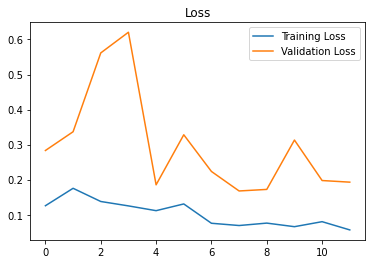

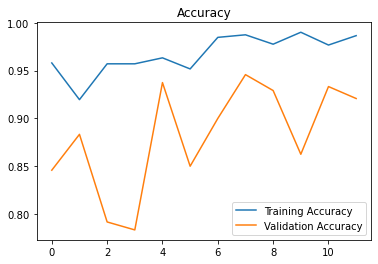

In [12]:
history = model.history.history
    

train_loss = history['loss']
val_loss = history['val_loss']
train_acc = history['accuracy']
val_acc = history['val_accuracy']
    
#plot the loss
plt.figure()
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()
    
#plot the accuracy
plt.figure()
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()



In [13]:
#get the best model
best_model = load_model(filepath='model/tumor_detection-15-0.88.hdf5')

#test out model
loss, acc = best_model.evaluate(x=x_test, y=y_test)
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")


8/8 [==============================] - 4s 259ms/step - loss: 0.3538 - accuracy: 0.8792
Test Loss = 0.353809654712677
Test Accuracy = 0.8791666626930237


In [14]:
def data_percentage(y):
    
    m = len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive * 100.0) / m
    neg_prec = (n_negative * 100.0) / m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}") 

In [15]:
#examine the dataset that was used during the model training
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 1120
Percentage of positive examples: 49.910714285714285%, number of pos examples: 559
Percentage of negative examples: 50.089285714285715%, number of neg examples: 561
Validation Data:
Number of examples: 240
Percentage of positive examples: 55.0%, number of pos examples: 132
Percentage of negative examples: 45.0%, number of neg examples: 108
Testing Data:
Number of examples: 240
Percentage of positive examples: 45.416666666666664%, number of pos examples: 109
Percentage of negative examples: 54.583333333333336%, number of neg examples: 131
